In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-wilderness/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-wilderness/movies.csv
/kaggle/input/edsa-movie-recommendation-wilderness/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-wilderness/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-wilderness/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-wilderness/train.csv
/kaggle/input/edsa-movie-recommendation-wilderness/test.csv
/kaggle/input/edsa-movie-recommendation-wilderness/tags.csv
/kaggle/input/edsa-movie-recommendation-wilderness/links.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
rating = pd.read_csv('../input/edsa-movie-recommendation-wilderness/train.csv')
rating.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
movies = pd.read_csv('../input/edsa-movie-recommendation-wilderness/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# merging both the datasets on 'movieId' column
movie_rating = pd.merge(left=rating,right=movies,on='movieId')

In [6]:
movie_rating.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [7]:
movie_rating = movie_rating[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]
movie_rating.head()

,userId,movieId,title,genres,rating,timestamp
0,5163,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,4.0,1518349992
1,87388,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,3.5,1237455297
2,137050,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,4.0,1425631854
3,120490,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,4.5,1408228517
4,50616,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,4.5,1446941640


In [8]:
movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   title      object 
 3   genres     object 
 4   rating     float64
 5   timestamp  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 534.1+ MB


In [9]:
movie_rating.isnull().sum()

userId       0
movieId      0
title        0
genres       0
rating       0
timestamp    0
dtype: int64

In [10]:
# grouping the movies based on average rating
average_rating_movies = movie_rating.groupby('title')['rating'].mean().sort_values(ascending=False)

In [11]:
average_rating_movies.head(10)

title
Which Way Home (2009)               5.0
Kaakha Kaakha (2003)                5.0
Not Quite Human II (1989)           5.0
Selling Isobel (2018)               5.0
Sehar (2005)                        5.0
The Enchanted Sedan Chair (1905)    5.0
K.G.F: Chapter 1 (2018)             5.0
Hard Cash (2002)                    5.0
Everyone's Going to Die (2013)      5.0
Anything for Love (2016)            5.0
Name: rating, dtype: float64

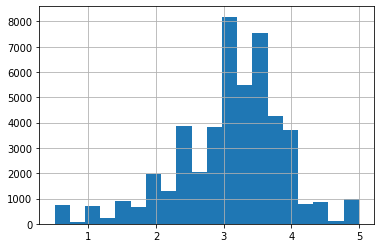

In [12]:
average_rating_movies.hist(bins=20)
plt.show()

In [13]:
# grouping the movies based on count of users who rated the movies
count_userid = movie_rating.groupby('title')['userId'].count().sort_values(ascending=False)

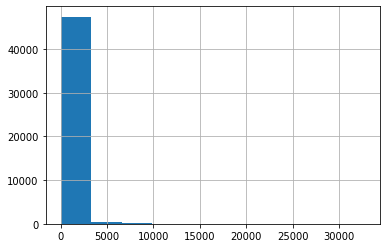

In [14]:
count_userid.hist()
plt.show()

In [15]:
# grouping the movie_rating based on count on userId and mean on rating
userid_rating = movie_rating.groupby('title')[['userId','rating']].agg({'userId':'count','rating':'mean'}).round(2).sort_values(by='userId',ascending=False)

In [16]:
userid_rating.head()

,userId,rating
title,,
"Shawshank Redemption, The (1994)",32831,4.42
Forrest Gump (1994),32383,4.05
Pulp Fiction (1994),31697,4.20
"Silence of the Lambs, The (1991)",29444,4.14
"Matrix, The (1999)",29014,4.15


In [17]:
import pandas as pd 
from tqdm import tqdm

chunk_size = 50000
chunks = [x for x in range(0, movie_rating.shape[0], chunk_size)]


pivot_df = pd.DataFrame()

for i in tqdm(range(0, len(chunks) - 1)):
    chunk_df = movie_rating.iloc[ chunks[i]:chunks[i + 1] - 1]
    interactions = (chunk_df.groupby(["userId", "title"])["rating"]
      .sum()
      .unstack()
      .reset_index()
      .fillna(0)
      .set_index("userId")
    )
#     print (interactions.shape)
    movie_rating_pivot = pivot_df.append(interactions, sort=False) 

100%|██████████| 200/200 [00:23<00:00,  8.55it/s]


In [18]:
from scipy import sparse
import numpy as np
sparse_matrix = sparse.csr_matrix(movie_rating_pivot.to_numpy())